In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import IPython.display as ipd
import librosa
from glob import glob
import time
from torch import nn
from torch.nn import functional as F
import torch
import torchvision
torch.cuda.is_available()

True

In [3]:
from birds_utils import get_fourier_weights, DataGeneratorV2, Dataset, get_pytorch_model, get_pytorch_model_all_conv, split_files_simple, get_bin_audio

In [4]:
# sr = 44100
# class_audiofiles = np.load(f'class_audiofiles_{sr}.npy', allow_pickle=True)
# train_files, val_files, train_labels, val_labels = split_files_simple(class_audiofiles, ratio = 0.2)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
sr = 22050
saved_time = 264
# train_files = np.load(f'train_files_{sr}_{saved_time}.npy')
# train_labels = np.load(f'train_labels_{sr}_{saved_time}.npy')
# val_files = np.load(f'val_files_{sr}_{saved_time}.npy')
# val_labels = np.load(f'val_labels_{sr}_{saved_time}.npy')
train_files = np.load(f'train_files_{sr}_{saved_time}.npy')
train_labels = np.load(f'train_labels_{sr}_{saved_time}.npy')
val_files = np.load(f'val_files_{sr}_{saved_time}.npy')
val_labels = np.load(f'val_labels_{sr}_{saved_time}.npy')

sr = 22050
train_files = [f.replace('npy_44100', 'npy_22050').replace('npy', 'bin') for f in train_files]
val_files = [f.replace('npy_44100', 'npy_22050').replace('npy', 'bin') for f in val_files]

std_stats = np.load('files_std_data.npy', allow_pickle=True).item()

In [7]:
# verificar que no haya superposición entre train y val
for file in train_files:
    if file in val_files:
        print(file)

In [8]:
len(val_files), len(train_files)

(4275, 17078)

In [9]:
# std_stats
from birds_utils import get_audio_chunk, get_bin_audio

In [10]:
N = 2
min_std = 0.5
duration = 5

params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}
classes = np.unique(train_labels)
n_classes = len(classes)
training_set = Dataset(list(train_files)*N, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=True, add_ambient_noise=True)
validation_set = Dataset(list(val_files)*N, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=False, add_ambient_noise=True)
training_generator = torch.utils.data.DataLoader(training_set, **params)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [11]:
for i, (X, y) in enumerate(validation_generator):
    print(i, X.shape, y.shape)
    break

0 torch.Size([64, 1, 110250]) torch.Size([64, 264])


In [12]:
# Load model
window_size = 1024
model = get_pytorch_model_all_conv(window_size, resnet='resnet18', pretrained=True, n_classes=n_classes, init_fourier=True, train_fourier=False).to(device)
# state_dict = torch.load('model_best_multilabel.pth', map_location=torch.device('cuda'))
# model.load_state_dict(state_dict)

Using cache found in /home/usuario/.cache/torch/hub/pytorch_vision_v0.6.0


In [13]:
# plt.plot(get_ambient_noise(1000, 22050))

In [14]:
model.eval()
spec, y_pred = model(X.to(device))
spec.shape, y_pred.shape

(torch.Size([64, 512, 427]), torch.Size([64, 264]))

1.0805842
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.

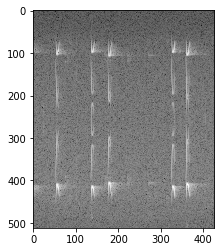

In [15]:
N = 1
sample_audio = X.detach().cpu().numpy()[N]
sample_spectrogram = spec.detach().cpu().numpy()[N, :,:]
plt.imshow(np.flipud(sample_spectrogram), cmap='gray')
print(sample_audio.std())
print(y[N])
ipd.Audio(sample_audio.reshape(-1), rate=sr)

In [16]:
spec.max(), spec.min()

(tensor(1.0733, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-0.2203, device='cuda:0', grad_fn=<MinBackward1>))

In [17]:
from birds_utils import validate, multilabel_metrics, get_F1_micro

In [18]:
import time
from datetime import timedelta

In [19]:
def train_model(model, dataset, validation_generator, criterion, name, metrics_func=multilabel_metrics, epochs=1, best_metric = 0):
    model.train()
    batches_per_epoch = len(dataset)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        TPs = 0
        FPs = 0
        FNs = 0
        total_predictions = 0
        model.train()
        start_time = time.time()
        for i, (X, y) in enumerate(dataset):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = X.to(device), y.to(device)
            # (1) Initialise gradients
            optimizer.zero_grad()
            # (2) Forward pass
            _, y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            running_loss = running_loss + loss
            # (3) Backward
            loss.backward()
            # (4) Compute the loss and update the weights
            optimizer.step()
            TP, FP, FN, micro_F1, total = metrics_func(y_pred, labels)
            TPs = TPs + TP.sum()
            FPs = FPs + FP.sum()
            FNs = FNs + FN.sum()
            total_predictions = total_predictions + total
            
            avg_loss = running_loss/(i+1)
            avg_F1 = get_F1_micro(TPs, FPs, FNs)
            avg_acc = TPs/total_predictions
            print(f'\r{epoch+1}/{epochs} - {i+1}/{batches_per_epoch} - loss: {avg_loss}, F1 micro: {avg_F1}, acc: {avg_acc}', end=', ')
        elapesed_time = (time.time() - start_time)
        print(f'elapesed_time: {timedelta(seconds=elapesed_time)}')
        
        avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)
        if avg_F1>best_metric:
            best_metric = avg_F1
            print()
            print('Best model saved')
            torch.save(model.state_dict(), f'{name}_{int(best_metric*1000 + 0.5)/1000}.pth')
        else:
            print()
        print('--------------------------------------------------------------------------')
        

In [20]:
from birds_utils import FakeDataset

In [21]:
params_train = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 0,
              'timeout': 0
             }
classes = np.unique(train_labels)

N = 2

training_set = Dataset(list(train_files)*N, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=True, add_ambient_noise=True)
validation_set = Dataset(list(val_files)*N*2, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=False, add_ambient_noise=True)
training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)


# training_set = FakeDataset(list(train_files[:1024])*N, n_classes, duration, sr)
# validation_set = FakeDataset(list(val_files[:1024])*N, n_classes, duration, sr)


# from birds_utils import DatasetSequence
# training_generator = DatasetSequence(list(train_files)*2, classes, batch_size=32, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=True, add_ambient_noise=True)
# validation_generator = DatasetSequence(list(train_files), classes, batch_size=32, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=False, add_ambient_noise=False)

In [22]:
# avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)

In [23]:
LEARNING_RATE = 0.001
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# state_dict = torch.load('model_6_0.8288726210594177.pth', map_location=torch.device('cuda'))
# model.load_state_dict(state_dict)

In [24]:
# avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)

In [ ]:
train_model(model, training_generator, validation_generator, criterion, 'model_ambient_150', 
            epochs=10, metrics_func=multilabel_metrics, best_metric=0.4)

1/10 - 1068/1068 - loss: 0.025170983746647835, F1 micro: 0.0016860391478985548, acc: 0.0009661552612669766, elapesed_time: 0:26:30.210576
1069/1069 - val loss: 0.02632935717701912, val F1 micro: 0.015826784074306488 val acc: 0.0084210522472858431
--------------------------------------------------------------------------
2/10 - 1068/1068 - loss: 0.019192075356841087, F1 micro: 0.024273281916975975, acc: 0.012003747746348381, elapesed_time: 0:26:32.853183
1069/1069 - val loss: 0.020248662680387497, val F1 micro: 0.07575444132089615 val acc: 0.042865496128797534
--------------------------------------------------------------------------
3/10 - 194/1068 - loss: 0.017017407342791557, F1 micro: 0.08436182141304016, acc: 0.04349226504564285,  

In [ ]:
##### 14/20 - 340/340 - loss: 0.012936275452375412, F1 micro: 0.9772475361824036, acc: 0.9713182449340825
# 83/83 - val loss: 0.11272670328617096, val F1 micro: 0.8410007953643799 val acc: 0.7876039147377014
# Best model saved

In [21]:
torch.save(model.state_dict(), 'model_last_ml_std_auto_0.8750.pth')

In [ ]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
X_img = torch.from_numpy(np.random.rand(2, 1, 44100)).float()